# Amazon food review dataset apply RF to predict polarity review

Data set from https://www.kaggle.com/snap/amazon-fine-food-reviews

# Objective
Here try BOW,TFIDF,avg W2V, avg TFIDFW2V and different hyperparameter RF(no of base learner) 
# Import data and libraries
 
 

In [25]:
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
con = sqlite3.connect('database.sqlite') 
#get only +ve and -ve review 
raw_data = pd.read_sql_query("""SELECT * FROM Reviews WHERE Score != 3""", con) 

# Data preprocessing

In [26]:
filtered_data=raw_data
# Score>3 a positive rating, and score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
#filtered_data.sample(5)
filtered_data['Score'].value_counts()
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
#Deduplication of entries for same profilename,userid, time, text and take first element 
sorted_data=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)

In [27]:
#take only 2500 + 2500 data
from sklearn.cross_validation import train_test_split,KFold
_ , clean_data = train_test_split(sorted_data, test_size = 40000, random_state=0,stratify = sorted_data['Score'] )
clean_data['Score'].value_counts()

positive    33727
negative     6273
Name: Score, dtype: int64

In [28]:
# Clean html tag and punctuation
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer
#substitute html tag and punctuation
def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
#print(sno.stem('tasty'))

i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
#Create new catagory as Cleanedtext after removing htmltag and punctuation and uppercase and word length >2
for sent in clean_data['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (clean_data['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(clean_data['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    
    final_string.append(str1)
    i+=1  
    
clean_data['CleanedText']=final_string
clean_data.shape
#Sort data on timestamp
clean_data=clean_data.sort_values(by=['Time'],ascending=False)
clean_data.sample(2)



,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
242151,262623,B003UGZOC0,A1I4M2EYH36A5V,Shannon Joyce,3,3,positive,1322352000,High Quality from Hill's,"We live in Santiago, Chile and the pickings we...",b'live santiago chile pick slim far qualiti co...
320453,346891,B003CZG0SG,A1BEHDHARZDIMR,"Tammie Sokoloff ""Nashira""",2,2,positive,1295222400,THE BEST!!!,"This stuff is great, tastes just like sugar an...",b'stuff great tast like sugar measur like suga...


# Split train and test data

In [29]:
x=clean_data['CleanedText'].values
y = clean_data['Score']
n=x.shape[0]
n1=int(n*.3)
X_test_raw = x[0:n1]
X_train_raw= x[n1:n+1]
y_test=y[0:n1]
y_train=y[n1:n+1]
print('size of X_train, X_test, y_train , y_test ',X_train_raw.shape, X_test_raw.shape,y_train.shape,y_test.shape)
print("positive and negative review in train and test\n",y_train.value_counts(),"\n",y_test.value_counts())

size of X_train, X_test, y_train , y_test  (28000,) (12000,) (28000,) (12000,)
positive and negative review in train and test
 positive    23774
negative     4226
Name: Score, dtype: int64 
 positive    9953
negative    2047
Name: Score, dtype: int64


# Build Random Forest
# BOW

#plot accuracy with k value

In [19]:
#now convert CleanedText to TDM
count_vect = CountVectorizer() #in scikit-learn
X_train = count_vect.fit_transform(X_train_raw)

#use the same vectors to convert test data
X_test=count_vect.transform(X_test_raw)
print(X_train.get_shape(),X_test.get_shape())

#print(final_counts[0,:])# this is stored like dict format only non zero values. sparse matrix
#x = pd.DataFrame(final_counts.toarray())#this is stored like dataframe format all 0 and non zero values. dense matrix
# sparse matrix in csr format works faster compare to dense format
#print(x.shape,x.loc[0])# sparse matrix in csr format works faster compare to dense format
#print(x.shape,x.loc[0])

# Use RF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
#RandomForestClassifier(n_estimators=10)
from sklearn.grid_search import GridSearchCV

#GradientBoostingClassifier(learning_rate=0.1, n_estimators=100, max_depth=3, random_state=0)

n_estimators=[10,50,100]

tuned_parameters=dict(n_estimators=n_estimators)

#Using GridSearchCV
model = GridSearchCV(RandomForestClassifier(), tuned_parameters, cv=5)
model.fit(X_train, y_train)


print('Best parameters \n',model.best_estimator_)
#print('Model test score', model.score(X_test, y_test))

optimumn_estimators=model.best_estimator_.n_estimators

#build model with optimum parameter
model = RandomForestClassifier(n_estimators=optimumn_estimators)
model.fit(X_train, y_train)

#Store scores
pred=model.predict(X_test)
mat=pd.crosstab(y_test, pred, rownames=['Actual'], colnames=['Predicted'], margins=True) 
tp=mat.iloc[1,1] ;tn=mat.iloc[0,0] ;fp=mat.iloc[0,1];fn=mat.iloc[1,0];precision=tp/(tp+fp) 
recall=tp/(tp+fn);fscoretest=2*precision*recall/(precision+recall)

pred=model.predict(X_train)
mat=pd.crosstab(y_train, pred, rownames=['Actual'], colnames=['Predicted'], margins=True) 
print(mat);tp=mat.iloc[1,1] ;tn=mat.iloc[0,0];fp=mat.iloc[0,1] ;fn=mat.iloc[1,0] ;precision=tp/(tp+fp);
recall=tp/(tp+fn);fscoretrain=2*precision*recall/(precision+recall)


aa=pd.DataFrame({'type':['BOW RF'],'depth':['na'],'estimator':[optimumn_estimators], \
                  'learningrate':['na'],'accuracy_train':[model.score(X_train,y_train)], \
                 'fscore_train':[fscoretrain],'accuracy_test':[model.score(X_test,y_test)],'fscore_test':[fscoretest]})

(28000, 20761) (12000, 20761)
Best parameters 
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Predicted  negative  positive    All
Actual                              
negative       4225         1   4226
positive          0     23774  23774
All            4225     23775  28000


# TFIDF

In [20]:
tf_idf_vect = TfidfVectorizer()
final_counts = tf_idf_vect.fit_transform(X_train_raw)
#use the same vectors to convert test data
X_test=count_vect.transform(X_test_raw)

print(X_train.get_shape(),X_test.get_shape())
#Use scale of train and apply to test
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_mean=False).fit(X_train)
#X_train = scaler.transform(X_train)
#X_test  = scaler.transform(X_test)
print('size of X_train, X_test, y_train , y_test ',X_train.shape, X_test.shape,y_train.shape,y_test.shape)


# Use RF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
#RandomForestClassifier(n_estimators=10)
from sklearn.grid_search import GridSearchCV

#GradientBoostingClassifier(learning_rate=0.1, n_estimators=100, max_depth=3, random_state=0)

n_estimators=[10,50,100]

tuned_parameters=dict(n_estimators=n_estimators)

#Using GridSearchCV
model = GridSearchCV(RandomForestClassifier(), tuned_parameters, cv=5)
model.fit(X_train, y_train)


print('Best parameters \n',model.best_estimator_)
#print('Model test score', model.score(X_test, y_test))

optimumn_estimators=model.best_estimator_.n_estimators

#build model with optimum parameter
model = RandomForestClassifier(n_estimators=optimumn_estimators)
model.fit(X_train, y_train)

#Store scores
pred=model.predict(X_test)
mat=pd.crosstab(y_test, pred, rownames=['Actual'], colnames=['Predicted'], margins=True) 
tp=mat.iloc[1,1] ;tn=mat.iloc[0,0] ;fp=mat.iloc[0,1];fn=mat.iloc[1,0];precision=tp/(tp+fp) 
recall=tp/(tp+fn);fscoretest=2*precision*recall/(precision+recall)

pred=model.predict(X_train)
mat=pd.crosstab(y_train, pred, rownames=['Actual'], colnames=['Predicted'], margins=True) 
print(mat);tp=mat.iloc[1,1] ;tn=mat.iloc[0,0];fp=mat.iloc[0,1] ;fn=mat.iloc[1,0] ;precision=tp/(tp+fp);
recall=tp/(tp+fn);fscoretrain=2*precision*recall/(precision+recall)


bb=pd.DataFrame({'type':['TFIDF RF'],'depth':['na'],'estimator':[optimumn_estimators], \
                  'learningrate':['na'],'accuracy_train':[model.score(X_train,y_train)], \
                 'fscore_train':[fscoretrain],'accuracy_test':[model.score(X_test,y_test)],'fscore_test':[fscoretest]})
aa=aa.append(bb)





(28000, 20761) (12000, 20761)
size of X_train, X_test, y_train , y_test  (28000, 20761) (12000, 20761) (28000,) (12000,)
Best parameters 
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Predicted  negative  positive    All
Actual                              
negative       4222         4   4226
positive          0     23774  23774
All            4222     23778  28000


# AVG W2V

In [36]:
#ignore warning
import warnings
warnings.filterwarnings('ignore')
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)
import gensim
i=0
#create a list of list to be used in W2V 
list_of_sent_train=[]
for sent in X_train_raw:  #clean_data['CleanedText'].values:
    filtered_sentence=[]
    #sent=cleanhtml(sent)
    for w in sent.split():
        #for cleaned_words in cleanpunc(w).split():
         for cleaned_words in w.split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower().decode('utf8'))
            else:
                continue 
    list_of_sent_train.append(filtered_sentence)
#convert each sentence's words to a vector of 50 dimension. Dont construct vec if word doesnot occur 5 times. And for each word construct 50 dimension vector
#and 4 core processor
w2v_model=gensim.models.Word2Vec(list_of_sent_train,min_count=5,size=50, workers=4)   

# average Word2Vec
# for each sentence make average of vectors by (vectors of each words)/(total no of words)
# compute average word2vec for each review.
sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent_train: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)  

    
#convert W2V test data
i=0
#create a list of list to be used in W2V 
list_of_sent_test=[]
for sent in X_test_raw:  #clean_data['CleanedText'].values:
    filtered_sentence=[]
    #sent=cleanhtml(sent)
    for w in sent.split():
        #for cleaned_words in cleanpunc(w).split():
         for cleaned_words in w.split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower().decode('utf8'))
            else:
                continue 
    list_of_sent_test.append(filtered_sentence)
#convert each sentence's words to a vector of 50 dimension. Dont construct vec if word doesnot occur 5 times. And for each word construct 50 dimension vector
#and 4 core processor
w2v_model=gensim.models.Word2Vec(list_of_sent_test,min_count=5,size=50, workers=4)   

# average Word2Vec
# for each sentence make average of vectors by (vectors of each words)/(total no of words)
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent_test: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)  

# try
X_train = pd.DataFrame(sent_vectors_train)
X_test = pd.DataFrame(sent_vectors_test)

#X_train = sent_vectors_train
#X_test = sent_vectors_test

#X_train_w2v=X_train
#X_test_w2v=X_test
print('size of X_train, X_test, y_train , y_test ',X_train.shape, X_test.shape,y_train.shape,y_test.shape)
#to avoid "ValueError: Input contains NaN, infinity or a value too large for dtype('float32')."
X_test.fillna(X_test.mean())
X_train.fillna(X_train.mean())

X_train=np.nan_to_num(X_train) # replace nan with zero and inf with finite numbers
X_test=np.nan_to_num(X_test) # replace nan with zero and inf with finite numbers

#np.nan_to_num(X_train)
#np.nan_to_num(X_test)


print("Checkinf for NaN and Inf")
print("np.inf=", np.where(np.isnan(X_train)))
print("is.inf=", np.where(np.isinf(X_train)))

n_estimators=[10,50,100]
tuned_parameters=dict(n_estimators=n_estimators)
model = GridSearchCV(RandomForestClassifier(), tuned_parameters, cv=5)
model.fit(X_train, y_train)
print('Best parameters \n',model.best_estimator_)
optimumn_estimators=model.best_estimator_.n_estimators
#build model with optimum parameter
model = RandomForestClassifier(n_estimators=optimumn_estimators)
model.fit(X_train, y_train)
#Store scores
pred=model.predict(X_test)
mat=pd.crosstab(y_test, pred, rownames=['Actual'], colnames=['Predicted'], margins=True) 
tp=mat.iloc[1,1] ;tn=mat.iloc[0,0] ;fp=mat.iloc[0,1];fn=mat.iloc[1,0];precision=tp/(tp+fp) 
recall=tp/(tp+fn);fscoretest=2*precision*recall/(precision+recall)

pred=model.predict(X_train)
mat=pd.crosstab(y_train, pred, rownames=['Actual'], colnames=['Predicted'], margins=True) 
print(mat);tp=mat.iloc[1,1] ;tn=mat.iloc[0,0];fp=mat.iloc[0,1] ;fn=mat.iloc[1,0] ;precision=tp/(tp+fp);
recall=tp/(tp+fn);fscoretrain=2*precision*recall/(precision+recall)

bb=pd.DataFrame({'type':['AVG W2V RF'],'depth':['na'],'estimator':[optimumn_estimators], \
                  'learningrate':['na'],'accuracy_train':[model.score(X_train,y_train)], \
                 'fscore_train':[fscoretrain],'accuracy_test':[model.score(X_test,y_test)],'fscore_test':[fscoretest]})
aa=aa.append(bb)

size of X_train, X_test, y_train , y_test  (28000, 50) (12000, 50) (28000,) (12000,)
Checkinf for NaN and Inf
np.inf= (array([], dtype=int64), array([], dtype=int64))
is.inf= (array([], dtype=int64), array([], dtype=int64))
Best parameters 
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Predicted  negative  positive    All
Actual                              
negative       4226         0   4226
positive          0     23774  23774
All            4226     23774  28000


# AVG TFIDF

In [37]:
#ignore warning
import warnings
warnings.filterwarnings('ignore')

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)
import gensim

tf_idf_vect = TfidfVectorizer()
final_tf_idf=tf_idf_vect.fit_transform(X_train_raw)
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
#calculate avg tfidf score for each sentences 
for sent in list_of_sent_train: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]#calculate w2v for each word
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf[row, tfidf_feat.index(word)]#get tfidf score of each word 
            sent_vec += (vec * tf_idf) # multiply vec with tfidf of each word and cumulative add of words in each sentence
            weight_sum += tf_idf # also add tfidf sums in each sentence
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1
#tfidf_sent_vectors.

# do for test
final_tf_idf=tf_idf_vect.transform(X_test_raw)
tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
#calculate avg tfidf score for each sentences 
for sent in list_of_sent_test: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]#calculate w2v for each word
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf[row, tfidf_feat.index(word)]#get tfidf score of each word 
            sent_vec += (vec * tf_idf) # multiply vec with tfidf of each word and cumulative add of words in each sentence
            weight_sum += tf_idf # also add tfidf sums in each sentence
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

#X_train = pd.DataFrame(tfidf_sent_vectors_train)
#X_test = pd.DataFrame(tfidf_sent_vectors_test)

X_train = tfidf_sent_vectors_train
X_test = tfidf_sent_vectors_test

#print('size of X_train, X_test, y_train , y_test ',X_train.shape, X_test.shape,y_train.shape,y_test.shape)

#to avoid "ValueError: Input contains NaN, infinity or a value too large for dtype('float32')."
#X_test.fillna(X_test.mean())
#X_train.fillna(X_train.mean())
X_train=np.nan_to_num(X_train) # replace nan with zero and inf with finite numbers
X_test=np.nan_to_num(X_test) # replace nan with zero and inf with finite numbers

#X_train=np.nan_to_num(X_train) # replace nan with zero and inf with finite numbers


n_estimators=[10,50,100]
tuned_parameters=dict(n_estimators=n_estimators)
model = GridSearchCV(RandomForestClassifier(), tuned_parameters, cv=5)
model.fit(X_train, y_train)
print('Best parameters \n',model.best_estimator_)
optimumn_estimators=model.best_estimator_.n_estimators
#build model with optimum parameter
model = RandomForestClassifier(n_estimators=optimumn_estimators)
model.fit(X_train, y_train)
#Store scores
pred=model.predict(X_test)
mat=pd.crosstab(y_test, pred, rownames=['Actual'], colnames=['Predicted'], margins=True) 
tp=mat.iloc[1,1] ;tn=mat.iloc[0,0] ;fp=mat.iloc[0,1];fn=mat.iloc[1,0];precision=tp/(tp+fp) 
recall=tp/(tp+fn);fscoretest=2*precision*recall/(precision+recall)

pred=model.predict(X_train)
mat=pd.crosstab(y_train, pred, rownames=['Actual'], colnames=['Predicted'], margins=True) 
print(mat);tp=mat.iloc[1,1] ;tn=mat.iloc[0,0];fp=mat.iloc[0,1] ;fn=mat.iloc[1,0] ;precision=tp/(tp+fp);
recall=tp/(tp+fn);fscoretrain=2*precision*recall/(precision+recall)

bb=pd.DataFrame({'type':['AVG W2V RF'],'depth':['na'],'estimator':[optimumn_estimators], \
                  'learningrate':['na'],'accuracy_train':[model.score(X_train,y_train)], \
                 'fscore_train':[fscoretrain],'accuracy_test':[model.score(X_test,y_test)],'fscore_test':[fscoretest]})
aa=aa.append(bb)

Best parameters 
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Predicted  negative  positive    All
Actual                              
negative       4226         0   4226
positive          0     23774  23774
All            4226     23774  28000


# Plot accuracy with n_extimator

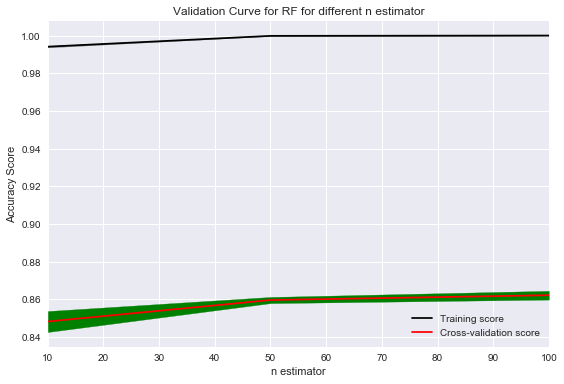

In [38]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import validation_curve
#create plot for training and test validation
# We cannot put 0 in parameter it will give error while validation_curve
n_estimators=[10,50,100]
param_range=[10,50,100]

train_scores, test_scores = validation_curve(RandomForestClassifier(), X_train, y_train, param_name="n_estimators", \
                                             param_range=n_estimators,cv=5)
#print(train_scores,test_scores)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_scores_mean, label="Training score", color="black")
plt.plot(param_range, test_scores_mean, label="Cross-validation score", color="red")
plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, color="gray")
plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, color="green")
plt.title("Validation Curve for RF for different n estimator")
plt.xlabel("n estimator")
plt.ylabel("Accuracy Score")
plt.xlim(10,100)
plt.tight_layout()
plt.legend(loc="best")
plt.show()


# Steps followed
Only !=3 reviews are taken Mark >3 as positive and <3 as negative. Sort data as per product id in ascending order Deduplication of entries for same profilename,userid, time, text and take first element Get stratified sampling of 50k data Clean html and punctuation Convert to uppercase and word<3 are rejected data sorted on time Split the data in train and test to 70:30

BOW
BOW BOW vec created using train data test data is converted using above on train and same applied to test 
do grid search for different value of n_estimator best model is established with best hyperparameter. model metric is stored in dataframe and crosstable is printed.

TFIDF
TFIDF form tfidf vec using train same is used in test to convert rest are same


AVG W2V 
gensim is used to convert train and test text to W2V AVG seperately rest are same

AVG TFIDF 
form tfidf vec using train same is used in test to convert gensim and above tfidf is used to convert train and test text to W2V AVG seperately

plot cv error with n_estimator

Below is metric

In [40]:
aa

,accuracy_test,accuracy_train,depth,estimator,fscore_test,fscore_train,learningrate,type
0,0.858583,0.999964,na,50,0.921191,0.999979,na,BOW RF
0,0.859167,0.999857,na,50,0.921534,0.999916,na,TFIDF RF
0,0.828667,1.000000,na,100,0.905558,1.000000,na,AVG W2V RF
0,0.849500,1.000000,na,100,0.915536,1.000000,na,AVG W2V RF
